In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from __future__ import annotations
from statsmodels.stats.outliers_influence import variance_inflation_factor
from pandas.api.types import is_numeric_dtype

In [2]:
# Komórka przechowująca reguralnie używane w tym pliku funkcje.

# Funkcja do wyświetlania pierwszych dziesięciu i ostatnich dziesięciu wierszy zbioru danych oraz do wyświetlania typów danych wszystkich zmiennych tego zbioru.
def dfhead_dftail_dftypes(df, ile):
    dfhead_dftail_dftypes = pd.concat([df.head(ile), df.tail(ile)])
    
    column_types = pd.DataFrame(df.dtypes, columns=['Type']).T
    column_types.columns = df.columns
    column_types.index = ['Column types']
    
    df_with_column_types = pd.concat([column_types, dfhead_dftail_dftypes])
    
    return df_with_column_types

# Funkcja do wyświetlania podstawowych informacji o zbiorze danych oraz do wypisywania liczby wierszy, kolumn i zdupikowanych wierszy tego zbioru.
def dfinfo_extra(df):
    df.info()
    print("\n" + f"Liczba wierszy: {df.shape[0]}")
    print(f"Liczba kolumn: {df.shape[1]}")
    print(f"Liczba zduplikowanych wierszy: {df.duplicated().sum()}")

# Funkcja do pozyskiwania nazw wszystkich zmiennych, numerycznych zmiennych i kategorycznych zmiennych zbioru danych.
def get_columns_name(df):
    all_columns_name = df.columns.tolist()
    numeric_columns_name = df.select_dtypes(include=['number']).columns.tolist()
    category_columns_name = df.select_dtypes(include=['object', 'category']).columns.tolist()
    
    return all_columns_name, numeric_columns_name, category_columns_name

# Funkcja do wyświetlania zestawienia podstawowych statystyk opisowych zmiennych numerycznych zbioru danych. Do tych statystyk funkcja dodaje medianę, dominantę i współczynnik zmienności.
def describe_numeric_extra(df):
    _, numeric_columns, _ = get_columns_name(df)
    numeric_df = df[numeric_columns]

    describe = numeric_df.describe(percentiles=[0.01, 0.05, 0.10, 0.25, 0.40,0.50, 0.60, 0.75, 0.90, 0.95, 0.99]).T

    describe['median'] = numeric_df.median()
    describe['mode']= numeric_df.mode().iloc[0]
    describe['wsp_zmien'] = describe['std'] / describe['mean']

    core   = ['count', 'mean', 'median', 'mode', 'std', 'wsp_zmien']
    others = [c for c in describe.columns if c not in core]

    return describe[core + others]

# Funkcja do wyświetlania zestawienia podstawowych statystyk opisowych zmiennych kategorycznych zbioru danych.
def describe_categoric_extra(df):
    _, _, category_columns_name = get_columns_name(df)
    category_df = df[category_columns_name]
    describe = category_df.describe().T
    
    return describe

# Funkcja do wyświetlania zestawienia zawierającego typy zmiennych zbioru danych oraz ilość brakujących, unikatowych i wszystkich niepustych wartości tych zmiennych.
def missing_unique_summary(df):
    df_missing_unique_summary = pd.DataFrame(df.dtypes, columns=['dtype'])
    df_missing_unique_summary['missing [#]'] = df.isna().sum()
    df_missing_unique_summary['missing [%]'] = df.isna().sum()/len(df)*100
    df_missing_unique_summary['unique'] = df.nunique().values
    df_missing_unique_summary['non unique'] = df.count().values - df.nunique().values
    df_missing_unique_summary['count'] = df.count().values
    
    return df_missing_unique_summary.style.background_gradient(cmap='Purples')

# Funkcja wypisuje liczbę i nazwy kolumn w podziale na typy danych (oraz opcjonalnie unikatowe wartości zmiennych kategorycznych)
def wypisywanie_nazw_i_licznosci_typow_danych(df, rozpisanie=0):
    print('Występujące w podanym zbiorze danych typy zmiennych i ich liczba wystąpień: ')
    print(df.dtypes.value_counts(), "\n")

    all_columns_name, numeric_columns_name, categoric_columns_name = get_columns_name(df)
    print(f'W podanym zbiorze danych wszystkich zmiennych jest łącznie {len(all_columns_name)}, są to: \n{all_columns_name}', '\n')
    print(f'W podanym zbiorze danych zmiennych numerycznych jest łącznie {len(numeric_columns_name)}, są to: \n{numeric_columns_name}', '\n')
    print(f'W podanym zbiorze danych zmiennych kategorycznych jest łącznie {len(categoric_columns_name)}, są to: \n{categoric_columns_name}')
    
    # Wyświetlenie unikatowych wartości zmiennych kategorycznych zbioru danych.
    if rozpisanie == 1:
        print()
        for col in categoric_columns_name:
            print(df[col].value_counts(),"\n")

    return all_columns_name, numeric_columns_name, categoric_columns_name

# Funkcja wizualizująca malejąco pod kątem ilości wystąpień unikatowe wartości zmiennych kategorycznych, które posiadają mniej niż 101 unikalnych wartości.
def zwizualizowanie_unikatowych_wartosci_zmiennych_kategorycznych_mniej_niz_101_wartosci(df):
    all_columns_name, numeric_columns_name, categoric_columns_name = get_columns_name(df)
    category_columns_with_less_than_101_values = [col for col in categoric_columns_name if df[col].nunique() < 101]

    print(f'W podanym zbiorze danych wszystkich zmiennych jest łącznie {len(all_columns_name)}, są to: \n{all_columns_name}', '\n')
    print(f'W podanym zbiorze danych zmiennych numerycznych jest łącznie {len(numeric_columns_name)}, są to: \n{numeric_columns_name}', '\n')
    print(f'W podanym zbiorze danych zmiennych kategorycznych jest łącznie {len(categoric_columns_name)}, są to: \n{categoric_columns_name}', '\n')
    
    print(f'W podanym zbiorze danych zmiennych kategorycznych, które mają mniej niż 101 unikatowych wartości jest łącznie {len(category_columns_with_less_than_101_values)}, są to: \n{category_columns_with_less_than_101_values}', '\n')

    for col in category_columns_with_less_than_101_values:
        plt.figure(figsize=(12, 6))
        value_counts = df[col].value_counts()
        value_counts.plot(kind='bar')
        plt.title(col)
        plt.xlabel(col)
        plt.ylabel('Count')
        
        # Dodanie nad każdą kolumną procentowej częstości wystąpień tej unikatowej wartości, którą reprezentuje.
        total = len(df[col])
        for i, count in enumerate(value_counts):
            percent = count / total * 100
            plt.annotate(f'{count}, ({percent:.1f}%)', xy=(i, count), ha='center', va='bottom', rotation=90, xytext=(0, 5), textcoords='offset points')
        
        plt.show()

In [90]:
df = pd.read_csv('kredyty_auto_Scoring2025s - Training.csv') # Wczytanie danych
dfhead_dftail_dftypes(df, 10) # Wyświetlenie pierwszych dziesięciu i ostatnich dziesięciu wierszy wczytanego zbioru danych oraz typów danych wszystkich zmiennych tego zbioru.

,LP,data_akceptacji,grupa_ryzyka,kod_partnera,typ_umowy,scoring_FICO,okres_kredytu,kwota_kredytu,oproc_refin,oproc_konkur,koszt_pieniadza,oproc_propon,akceptacja_klienta
Column types,int64,object,int64,int64,object,int64,int64,object,object,object,object,object,int64
0,1,17/4/2005,2,2,R,702,48,"$26,500",3.99%,4.99%,1.10%,6.59%,0
1,2,17/4/2005,2,2,N,719,72,"$35,000",0.00%,4.79%,1.10%,5.99%,0
2,3,17/4/2005,1,3,N,802,60,"$28,000",0.00%,3.99%,1.10%,3.55%,0
3,4,17/4/2005,1,1,R,723,60,"$20,751",6.75%,4.99%,1.10%,4.89%,1
4,5,17/4/2005,3,1,U,690,72,"$20,000",0.00%,5.29%,1.10%,6.79%,0
5,6,21/4/2005,1,3,N,681,60,"$38,000",0.00%,3.99%,1.10%,3.85%,0
6,7,17/4/2005,1,1,U,805,36,"$5,724",0.00%,4.05%,1.10%,3.89%,1
7,8,17/4/2005,2,2,R,726,60,"$21,596",5.99%,4.99%,1.10%,5.25%,0
8,9,17/4/2005,1,1,N,765,60,"$27,000",0.00%,3.99%,1.10%,3.85%,0


In [105]:
df["okres_kredytu"].value_counts()

okres_kredytu
60    19336
72     7932
36     6102
48     5585
66      988
Name: count, dtype: int64

In [91]:
del df["LP"]

dfhead_dftail_dftypes(df, 10) # Wyświetlenie pierwszych dziesięciu i ostatnich dziesięciu wierszy wczytanego zbioru danych oraz typów danych wszystkich zmiennych tego zbioru.

,data_akceptacji,grupa_ryzyka,kod_partnera,typ_umowy,scoring_FICO,okres_kredytu,kwota_kredytu,oproc_refin,oproc_konkur,koszt_pieniadza,oproc_propon,akceptacja_klienta
Column types,object,int64,int64,object,int64,int64,object,object,object,object,object,int64
0,17/4/2005,2,2,R,702,48,"$26,500",3.99%,4.99%,1.10%,6.59%,0
1,17/4/2005,2,2,N,719,72,"$35,000",0.00%,4.79%,1.10%,5.99%,0
2,17/4/2005,1,3,N,802,60,"$28,000",0.00%,3.99%,1.10%,3.55%,0
3,17/4/2005,1,1,R,723,60,"$20,751",6.75%,4.99%,1.10%,4.89%,1
4,17/4/2005,3,1,U,690,72,"$20,000",0.00%,5.29%,1.10%,6.79%,0
5,21/4/2005,1,3,N,681,60,"$38,000",0.00%,3.99%,1.10%,3.85%,0
6,17/4/2005,1,1,U,805,36,"$5,724",0.00%,4.05%,1.10%,3.89%,1
7,17/4/2005,2,2,R,726,60,"$21,596",5.99%,4.99%,1.10%,5.25%,0
8,17/4/2005,1,1,N,765,60,"$27,000",0.00%,3.99%,1.10%,3.85%,0


Statystyki opisowe

In [32]:
dfinfo_extra(df) # Wyświetlenie podstawowych informacji o zbiorze danych df_ALL.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   data_akceptacji     40000 non-null  object
 1   grupa_ryzyka        40000 non-null  int64 
 2   kod_partnera        40000 non-null  int64 
 3   typ_umowy           40000 non-null  object
 4   scoring_FICO        40000 non-null  int64 
 5   okres_kredytu       40000 non-null  int64 
 6   kwota_kredytu       40000 non-null  object
 7   oproc_refin         40000 non-null  object
 8   oproc_konkur        40000 non-null  object
 9   koszt_pieniadza     40000 non-null  object
 10  oproc_propon        40000 non-null  object
 11  akceptacja_klienta  40000 non-null  int64 
dtypes: int64(5), object(7)
memory usage: 3.7+ MB

Liczba wierszy: 40000
Liczba kolumn: 12
Liczba zduplikowanych wierszy: 57


In [92]:
df = df.drop_duplicates().reset_index(drop=True)
dfhead_dftail_dftypes(df, 10) # Wyświetlenie pierwszych dziesięciu i ostatnich dziesięciu wierszy wczytanego zbioru danych oraz typów danych wszystkich zmiennych tego zbioru.

,data_akceptacji,grupa_ryzyka,kod_partnera,typ_umowy,scoring_FICO,okres_kredytu,kwota_kredytu,oproc_refin,oproc_konkur,koszt_pieniadza,oproc_propon,akceptacja_klienta
Column types,object,int64,int64,object,int64,int64,object,object,object,object,object,int64
0,17/4/2005,2,2,R,702,48,"$26,500",3.99%,4.99%,1.10%,6.59%,0
1,17/4/2005,2,2,N,719,72,"$35,000",0.00%,4.79%,1.10%,5.99%,0
2,17/4/2005,1,3,N,802,60,"$28,000",0.00%,3.99%,1.10%,3.55%,0
3,17/4/2005,1,1,R,723,60,"$20,751",6.75%,4.99%,1.10%,4.89%,1
4,17/4/2005,3,1,U,690,72,"$20,000",0.00%,5.29%,1.10%,6.79%,0
5,21/4/2005,1,3,N,681,60,"$38,000",0.00%,3.99%,1.10%,3.85%,0
6,17/4/2005,1,1,U,805,36,"$5,724",0.00%,4.05%,1.10%,3.89%,1
7,17/4/2005,2,2,R,726,60,"$21,596",5.99%,4.99%,1.10%,5.25%,0
8,17/4/2005,1,1,N,765,60,"$27,000",0.00%,3.99%,1.10%,3.85%,0


In [7]:
dfinfo_extra(df) # Wyświetlenie podstawowych informacji o zbiorze danych df_ALL.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39943 entries, 0 to 39942
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   data_akceptacji     39943 non-null  object
 1   grupa_ryzyka        39943 non-null  int64 
 2   kod_partnera        39943 non-null  int64 
 3   typ_umowy           39943 non-null  object
 4   scoring_FICO        39943 non-null  int64 
 5   okres_kredytu       39943 non-null  int64 
 6   kwota_kredytu       39943 non-null  object
 7   oproc_refin         39943 non-null  object
 8   oproc_konkur        39943 non-null  object
 9   koszt_pieniadza     39943 non-null  object
 10  oproc_propon        39943 non-null  object
 11  akceptacja_klienta  39943 non-null  int64 
dtypes: int64(5), object(7)
memory usage: 3.7+ MB

Liczba wierszy: 39943
Liczba kolumn: 12
Liczba zduplikowanych wierszy: 0


In [8]:
missing_unique_summary(df) # Wyświetlenie zestawienia zawierającego typy zmiennych zbioru danych oraz ilość brakujących, unikatowych i wszystkich niepustych wartości dla każdej z tych zmiennych.

,dtype,missing [#],missing [%],unique,non unique,count
data_akceptacji,object,0,0.000000,168,39775,39943
grupa_ryzyka,int64,0,0.000000,4,39939,39943
kod_partnera,int64,0,0.000000,3,39940,39943
typ_umowy,object,0,0.000000,3,39940,39943
scoring_FICO,int64,0,0.000000,246,39697,39943
okres_kredytu,int64,0,0.000000,5,39938,39943
kwota_kredytu,object,0,0.000000,12141,27802,39943
oproc_refin,object,0,0.000000,688,39255,39943
oproc_konkur,object,0,0.000000,37,39906,39943
koszt_pieniadza,object,0,0.000000,56,39887,39943


In [9]:
describe_numeric_extra(df) # Wyświetlenie zestawienia podstawowych statystyk opisowych zmiennych numerycznych

,count,mean,median,mode,std,wsp_zmien,min,1%,5%,10%,25%,40%,50%,60%,75%,90%,95%,99%,max
grupa_ryzyka,39943.0,2.053902,2.0,1,1.090481,0.530931,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,3.0,4.0,4.0,4.0,4.0
kod_partnera,39943.0,2.102746,2.0,3,0.912807,0.434102,1.0,1.0,1.0,1.0,1.0,2.0,2.0,3.0,3.0,3.0,3.0,3.0,3.0
scoring_FICO,39943.0,720.712490,717.0,705,46.580024,0.064631,601.0,641.0,650.0,660.0,684.0,704.0,717.0,730.0,755.0,787.0,803.0,825.0,851.0
okres_kredytu,39943.0,57.187092,60.0,60,11.388858,0.199151,36.0,36.0,36.0,36.0,48.0,60.0,60.0,60.0,60.0,72.0,72.0,72.0,72.0
akceptacja_klienta,39943.0,0.259545,0.0,0,0.438390,1.689074,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0


In [10]:
describe_categoric_extra(df) # Wyświetlenie zestawienia podstawowych statystyk opisowych zmiennych kategorycznych

,count,unique,top,freq
data_akceptacji,39943,168,6/7/2005,487
typ_umowy,39943,3,U,14367
kwota_kredytu,39943,12141,"$30,000",1824
oproc_refin,39943,688,0.00%,28655
oproc_konkur,39943,37,5.39%,3543
koszt_pieniadza,39943,56,1.10%,9369
oproc_propon,39943,468,4.49%,2464


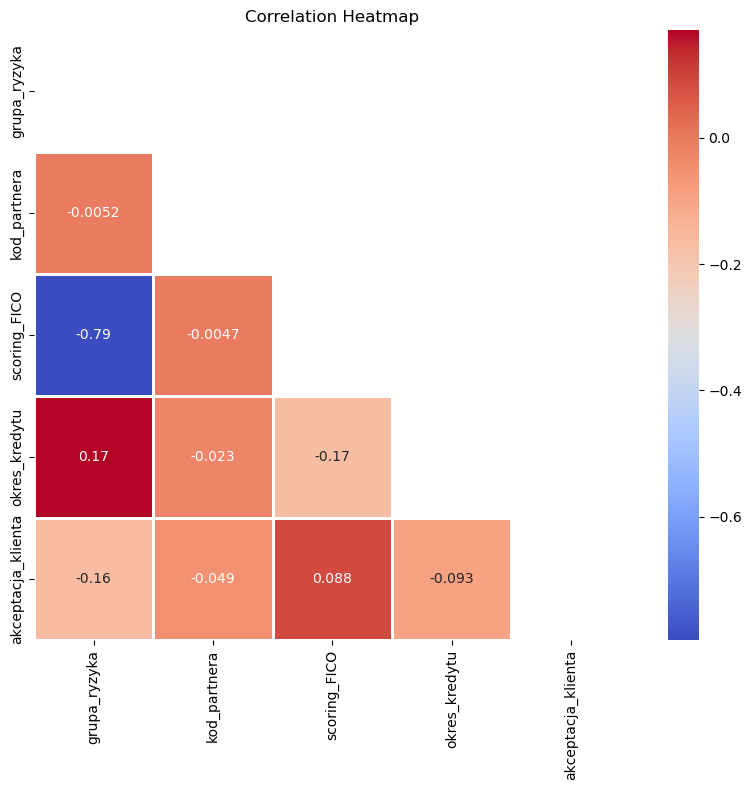

In [11]:
df_numeric = df.select_dtypes(include=['number'])

plt.figure(figsize=(8, 8))
corr = df_numeric.corr()
mask = np.triu(np.ones_like(corr))
sns.heatmap(corr, annot=True, mask=mask, cmap='coolwarm', linewidth=2, annot_kws={'size': 10})
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

W podanym zbiorze danych wszystkich zmiennych jest łącznie 12, są to: 
['data_akceptacji', 'grupa_ryzyka', 'kod_partnera', 'typ_umowy', 'scoring_FICO', 'okres_kredytu', 'kwota_kredytu', 'oproc_refin', 'oproc_konkur', 'koszt_pieniadza', 'oproc_propon', 'akceptacja_klienta'] 

W podanym zbiorze danych zmiennych numerycznych jest łącznie 5, są to: 
['grupa_ryzyka', 'kod_partnera', 'scoring_FICO', 'okres_kredytu', 'akceptacja_klienta'] 

W podanym zbiorze danych zmiennych kategorycznych jest łącznie 7, są to: 
['data_akceptacji', 'typ_umowy', 'kwota_kredytu', 'oproc_refin', 'oproc_konkur', 'koszt_pieniadza', 'oproc_propon'] 

W podanym zbiorze danych zmiennych kategorycznych, które mają mniej niż 101 unikatowych wartości jest łącznie 3, są to: 
['typ_umowy', 'oproc_konkur', 'koszt_pieniadza'] 



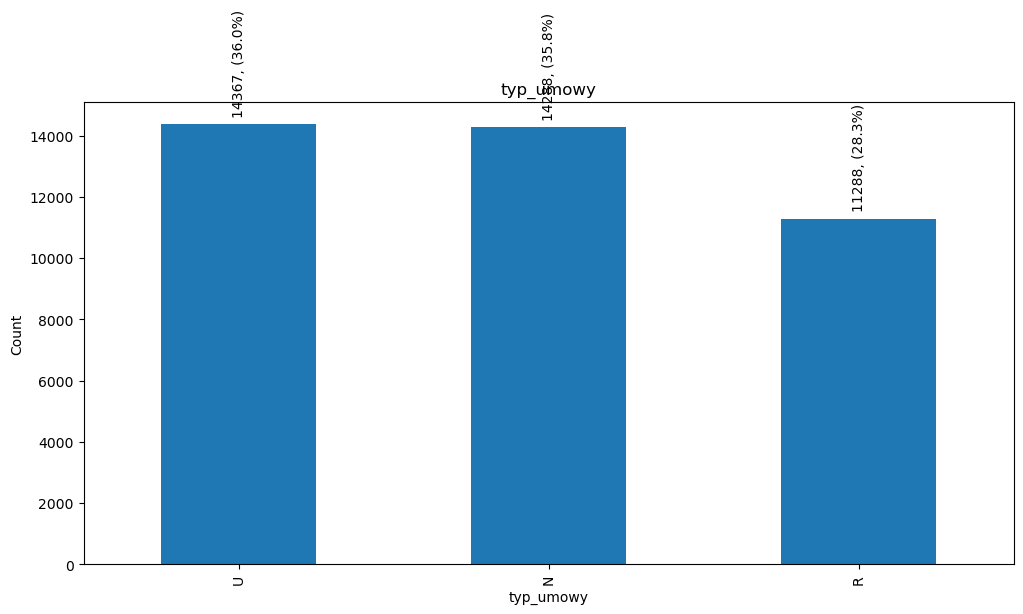

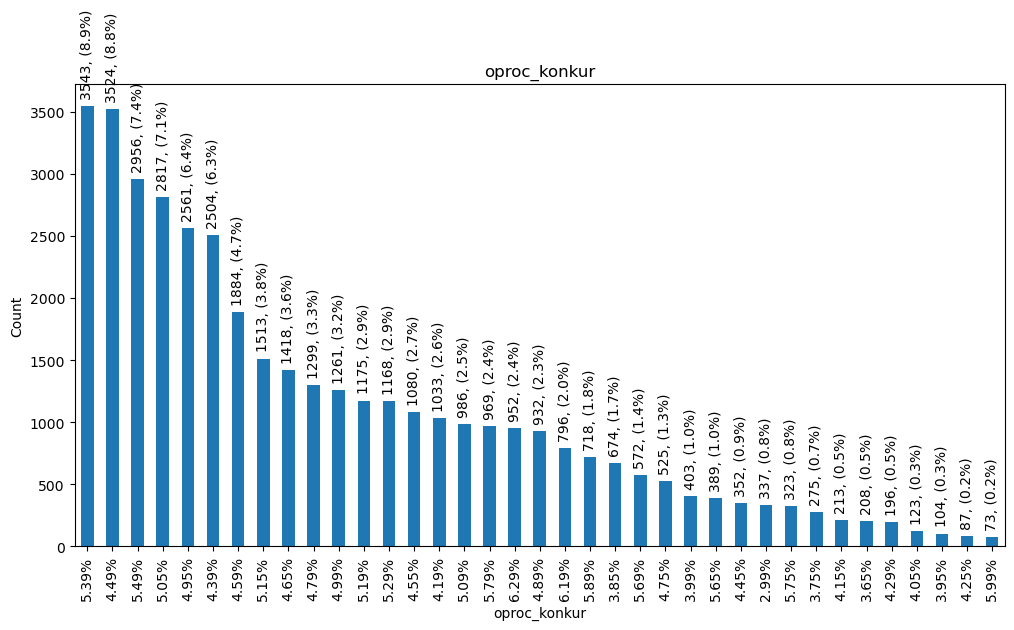

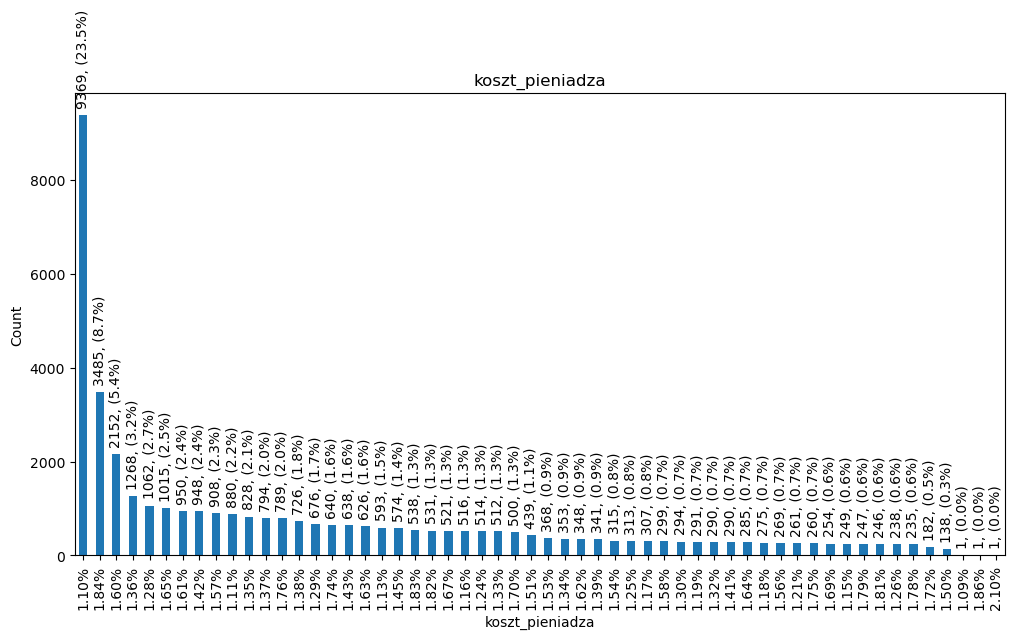

In [12]:
zwizualizowanie_unikatowych_wartosci_zmiennych_kategorycznych_mniej_niz_101_wartosci(df)

Zmienne pochodne

##############################################################################
 LEGENDA ZMIENNYCH – engineer_credit_features()
##############################################################################

 rok, miesiac, kwartal
     • Rok / miesiąc / kwartał  daty akceptacji
     • Uchwycenie sezonowych cykli sprzedaży i zmian polityki banku w czasie.

 dzien_tyg
     • Dzień tygodnia (0 = poniedziałek).
     • Wiele portfeli obserwuje niższą konwersję w piątki/weekendy; model
       może skorygować ten efekt bez mieszania z innymi cechami.

 dzien_roku, tydzien_roku
     • Kolejny dzień / tydzień roku (1-366, 1-53).
     • Finer-grained seasonality: wyprzedaże sezonowe, Black Friday, koniec roku.

 koniec_mies
     • 1 jeśli data przypada na ostatni dzień miesiąca.
     • Partnerzy „domykają budżet” – inne zachowania cenowe i decyzyjne.

 marza_banku_bps
     • (opropon − koszt_pieniadza) * 10 000 bp.
     • Realna rentowność kredytu; balans z prawdopodobieństwem akceptacji.

 spread_propon_konkur_bps
     • (opropon − oproc_konkur) * 10 000 bp.
     • Bezpośredni miernik atrakcyjności ceny vs. rynek – klucz do decyzji klienta.

 spread_propon_refin_bps
     • (opropon − oproc_refin) * 10 000 bp (tylko dla typ „R”).
     • Pokazuje, czy refinansowanie przynosi klientowi oszczędność.

 spread_refin_missing
     • 1 gdy powyższe NaN.
     • Flaga „refinansowanie nie dotyczy” – ważne przy modelach bez NaN.

 czy_refinansowanie
     • 1 dla umów typu „R”.
     • Pozwala odróżnić segment refinansów od nowych/używanych kredytów.

 czy_auto_uzywane
     • 1 dla umów typu „U”.
     • Używane auta mają zwykle wyższe stopy i niższą akceptację.

 refin_aktywny
     • 1, gdy klient spłaca poprzedni kredyt (stopa > 0 %).
     • Oddziela prawdziwy refi od technicznych „R-0 %” w danych.

 brak_stopy_konkurencji
     • 1 jeśli oproc_konkur = NaN.
     • Pozwala modelowi odróżnić „brak danych” od „zerowej różnicy”.

 oferta_lepsza_niz_konkur
     • 1 gdy opropon < oproc_konkur.
     • Łatwy do interpretacji sygnał „atrakcyjna vs. nieatrakcyjna cena”.

 rata_mies
     • Miesięczna rata annuitetowa (PMT).
     • Kluczowy dla klienta – patrzy na ratę, nie na sam procent.

 koszt_calkowity
     • rata_mies * okres.
     • Całkowita suma do spłaty – obciążenie budżetu.

 kapital_na_mies
     • kwota / okres.
     • Uproszczony kapitał bez odsetek (fallback, gdy stopa = 0).

 kwota_na_punkt_fico
     • kwota_kredytu / scoring_FICO.
     • Relacja „duża kwota przy niskim FICO” = potencjalnie wysokie ryzyko.

 kwota_rel_do_risku
     • kwota / średnia kwota w swojej grupie ryzyka.
     • Normalizacja wielkości kredytu wewnątrz klas risk-bucketu.

 fico_z
     • Z-score FICO.
     • Centrowanie i skalowanie ułatwia uczenie regresji / NN.

 fico_kwartyl
     • Kwantyl FICO (0–3).
     • Dyskretyzacja pozwala modelowi liniowemu uchwycić nieliniowość bez polinomów.

 kwota_segment  + dummies kwota_seg_<…>
     • Przedziały kwoty: <15k / 15-30k / >30k.
     • Binning tłumi outliery i umożliwia osobne parametry dla każdego „koszyka”.

 okres_bucket  + dummies okres_<…>
     • Długość kredytu jako kategoria („36”, „48”, „60”, „72” mies.).
     • 48 m-cy nie jest połową drogi między 36 a 60 – kategoria oddaje dyskretne polityki banku.

 partner_freq
     • Udział danego partnera w całej próbce.
     • Informuje model o „wielkości” sieci dealerskiej (inne procedury, inne profile klientów).

 partner_avg_fico
     • Średni scoring_FICO klientów danego partnera.
     • Proxy jakości leadów – partner z wyższą średnią FICO może mieć wyższą akceptację.

 typ_U, typ_R  (one-hot)
     • Binarne flagi typów umowy; typ_N = baza.
     • Pozwalają modelowi mieć osobne współczynniki dla każdego typu.

 partner_2, partner_3  (one-hot)
     • Binarne flagi partnerów; partner_1 = baza.
     • Modele liniowe nie obsługują liczb kategorii – one-hot rozwiązuje problem.

 loan_x_spread_konkur
     • kwota_kredytu × spread_propon_konkur_bps.
     • Ta sama nadwyżka 50 bp ma większy wpływ przy kredycie 50k niż 5k.

 fico_x_kwota
     • scoring_FICO × kwota_kredytu.
     • Interakcja wielkości kredytu i zdolności kredytowej.

 fico_x_oproc_propon
     • scoring_FICO × oproc_propon.
     • Niski FICO + wysoka cena może zniechęcać mocniej niż suma obu czynników.

 marza_x_refin
     • marza_banku_bps × czy_refinansowanie.
     • Bank może przy refinansie akceptować inną (często niższą) marżę.

 (dodatkowe dummies ‘type_*’, ‘term_*’, ‘partner_*’ tworzy pd.get_dummies
  – każda kolumna to 0/1 wskazujące obecność danej kategorii).
##############################################################################

In [93]:
"""
Funkcja "engineer_credit_features" zwraca kopię wejściowego DataFrame rozszerzoną o zmienne pochodne opisane w specyfikacji (czasowe, marże, flagi, binning, interakcje, wielomiany).

"""
############################################
# I. POMOCNICZA FUNKCJA DO RATY ANNUITETOWEJ
############################################
def annuity_payment(annual_rate, months, principal):
    """Zwraca wysokość miesięcznej raty annuitetowej (stałej).

    Parametry
    ----------
    annual_rate: float
        Roczna stopa procentowa w postaci ułamka dziesiętnego, np. 0.0599 dla 5,99 %.
    months: int
        Liczba rat (okres kredytowania w miesiącach). 
    principal : float
        Kwota kredytu (kapitał początkowy).

    Zwraca
    -------
    float
        Dodatnia wartość raty miesięcznej.
    """
    r = annual_rate / 12            # Miesięczna stopa
    months = np.asarray(months, dtype=float) 
    principal = np.asarray(principal, dtype=float)
    
    zero_mask = (r == 0) | (months == 0) # Warunek zerowej stopy lub zerowego okresu

    # obliczenie raty
    payment = np.where(
        zero_mask,
        principal / np.where(months == 0, 1, months),     # kredyt bezodsetkowy
        principal * r / (1 - np.power(1 + r, -months))    # klasyczna rata annuitetowa
    )
    
    return payment

#####################################
# II. GŁÓWNA FUNKCJA: INŻYNIERIA CECH
#####################################
def engineer_credit_features(df):
    """
    Czyści dane i tworzy pełny zestaw zmiennych pochodnych.
    """
    
    # 1.1. KOPIA ROBOCZA
    df_feat = df.copy() # Oryginalny dateframe jest kopiowany w celu zmodyfikowania kopii, a nie oryginału

    # 1.2. CZYSZCZENIE FORMATÓW
    # Ustawienie formatu daty na DD/MM/YYYY
    df_feat["data_akceptacji"] = pd.to_datetime(df_feat["data_akceptacji"], dayfirst=True, errors="coerce"
)
    # Usunięcie symboli $ i % oraz konwersja na float
    PERCENT_COLS = ["oproc_refin", "oproc_konkur", "koszt_pieniadza", "oproc_propon",]
    MONEY_COLS = ["kwota_kredytu"]

    for col in PERCENT_COLS + MONEY_COLS:
        df_feat[col] = (
            df_feat[col]
            .astype(str)
            .str.replace(r"[\s\$,%,]", "", regex=True)
            .replace({"": np.nan, "nan": np.nan})
            .astype(float)
        )

    # Konwersja procentów na ułamki dziesiętne (5% ⇒ 0.05)
    df_feat[PERCENT_COLS] = df_feat[PERCENT_COLS] / 100

  
    # 2. CECHY CZASOWE
    d = df_feat["data_akceptacji"]  # d to alias skracający zapis

    df_feat["miesiac"]       = d.dt.month
    df_feat["dzien_tyg"]     = d.dt.dayofweek  # 0 = poniedziałek
    df_feat["tydzien_roku"]  = d.dt.isocalendar().week.astype(int)
    df_feat["koniec_mies"]   = d.dt.is_month_end.astype(int)

  
    # 3. MARŻE I RÓŻNICE OPROCENTOWAŃ (BPS)
    to_bps = lambda s: s * 10_000 # 1 pp = 100 bp, 0.01 = 100 bp

    df_feat["marza_banku_bps"] = to_bps(df_feat["oproc_propon"] - df_feat["koszt_pieniadza"])
    df_feat["spread_propon_konkur_bps"] = to_bps(df_feat["oproc_propon"] - df_feat["oproc_konkur"])
    
  
    # 4. FLAGI BINARNE
    df_feat["czy_refinansowanie"] = (df_feat["typ_umowy"] == "R").astype(int)
    df_feat["czy_auto_uzywane"] = (df_feat["typ_umowy"] == "U").astype(int)
    df_feat["oferta_lepsza_niz_konkur"] = (df_feat["spread_propon_konkur_bps"] < 0).astype(int)

  
    # 5.  PARAMETRY KREDYTU (RATA, KOSZTY, RELACJE KWOTOWE)
    df_feat["rata_mies"] = annuity_payment(annual_rate=df_feat["oproc_propon"], months=df_feat["okres_kredytu"], principal=df_feat["kwota_kredytu"],)

    df_feat["koszt_calkowity"] = df_feat["rata_mies"] * df_feat["okres_kredytu"]
    df_feat["kapital_na_mies"] = df_feat["kwota_kredytu"] / df_feat["okres_kredytu"]
    df_feat["kwota_na_punkt_fico"] = df_feat["kwota_kredytu"] / df_feat["scoring_FICO"]

    # Kwota względna w swojej grupie ryzyka ---------------------------
    avg_kwota_per_risk = df_feat.groupby("grupa_ryzyka")["kwota_kredytu"].transform("mean")
    df_feat["kwota_rel_do_risku"] = df_feat["kwota_kredytu"] / avg_kwota_per_risk


    # 6.  STANDARYZACJA I BINNING ZMIENNYCH CIĄGŁYCH
    df_feat["fico_kwartyl"] = pd.qcut(df_feat["scoring_FICO"], q=4, labels=False, duplicates="drop")
    df_feat["kwota_segment"] = pd.cut(df_feat["kwota_kredytu"], bins=[0, 15_000, 30_000, np.inf], labels=["<15k", "15-30k", ">30k"],)
    df_feat["okres_bucket"] = df_feat["okres_kredytu"].astype(str)  # „36”, „48”…


    # 7.  KODOWANIE ZMIENNYCH KATEGORYCZNYCH
    partner_avg_fico = (df_feat.groupby("kod_partnera")["scoring_FICO"].transform("mean"))
    df_feat["partner_high_fico_flag"] = (partner_avg_fico > df_feat["scoring_FICO"].mean()).astype(int)
    
    df_feat = pd.get_dummies( df_feat,columns=["typ_umowy", "okres_bucket", "kod_partnera", "kwota_segment"],prefix=["typ", "okres", "partner", "kwota_seg"],drop_first=True,)

    # 8.  INTERAKCJE EKONOMICZNE
    df_feat["fico_x_kwota"] = df_feat["scoring_FICO"] * df_feat["kwota_kredytu"]
    df_feat["fico_x_oproc_propon"] = df_feat["scoring_FICO"] * df_feat["oproc_propon"]
    df_feat["marza_x_refin"] = df_feat["marza_banku_bps"] * df_feat["czy_refinansowanie"]

    
    return df_feat

df_new = engineer_credit_features(df)
dfhead_dftail_dftypes(df_new, 10) # Wyświetlenie pierwszych dziesięciu i ostatnich dziesięciu wierszy wczytanego zbioru danych oraz typów danych wszystkich zmiennych tego zbioru.

,data_akceptacji,grupa_ryzyka,scoring_FICO,okres_kredytu,kwota_kredytu,oproc_refin,oproc_konkur,koszt_pieniadza,oproc_propon,akceptacja_klienta,...,okres_60,okres_66,okres_72,partner_2,partner_3,kwota_seg_15-30k,kwota_seg_>30k,fico_x_kwota,fico_x_oproc_propon,marza_x_refin
Column types,datetime64[ns],int64,int64,int64,float64,float64,float64,float64,float64,int64,...,bool,bool,bool,bool,bool,bool,bool,float64,float64,float64
0,2005-04-17 00:00:00,2,702,48,26500.0,0.0399,0.0499,0.011,0.0659,0,...,False,False,False,True,False,True,False,18603000.0,46.2618,549.0
1,2005-04-17 00:00:00,2,719,72,35000.0,0.0,0.0479,0.011,0.0599,0,...,False,False,True,True,False,False,True,25165000.0,43.0681,0.0
2,2005-04-17 00:00:00,1,802,60,28000.0,0.0,0.0399,0.011,0.0355,0,...,True,False,False,False,True,True,False,22456000.0,28.471,0.0
3,2005-04-17 00:00:00,1,723,60,20751.0,0.0675,0.0499,0.011,0.0489,1,...,True,False,False,False,False,True,False,15002973.0,35.3547,379.0
4,2005-04-17 00:00:00,3,690,72,20000.0,0.0,0.0529,0.011,0.0679,0,...,False,False,True,False,False,True,False,13800000.0,46.851,0.0
5,2005-04-21 00:00:00,1,681,60,38000.0,0.0,0.0399,0.011,0.0385,0,...,True,False,False,False,True,False,True,25878000.0,26.2185,0.0
6,2005-04-17 00:00:00,1,805,36,5724.0,0.0,0.0405,0.011,0.0389,1,...,False,False,False,False,False,False,False,4607820.0,31.3145,0.0
7,2005-04-17 00:00:00,2,726,60,21596.0,0.0599,0.0499,0.011,0.0525,0,...,True,False,False,True,False,True,False,15678696.0,38.115,415.0
8,2005-04-17 00:00:00,1,765,60,27000.0,0.0,0.0399,0.011,0.0385,0,...,True,False,False,False,False,True,False,20655000.0,29.4525,0.0


In [21]:
df_new.to_csv("df_z_pochodnymi.csv", index=False)

In [94]:
dfinfo_extra(df_new) # Wyświetlenie podstawowych informacji o zbiorze danych df_ALL.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39943 entries, 0 to 39942
Data columns (total 39 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   data_akceptacji           39943 non-null  datetime64[ns]
 1   grupa_ryzyka              39943 non-null  int64         
 2   scoring_FICO              39943 non-null  int64         
 3   okres_kredytu             39943 non-null  int64         
 4   kwota_kredytu             39943 non-null  float64       
 5   oproc_refin               39943 non-null  float64       
 6   oproc_konkur              39943 non-null  float64       
 7   koszt_pieniadza           39943 non-null  float64       
 8   oproc_propon              39943 non-null  float64       
 9   akceptacja_klienta        39943 non-null  int64         
 10  miesiac                   39943 non-null  int32         
 11  dzien_tyg                 39943 non-null  int32         
 12  tydzien_roku      

In [95]:
missing_unique_summary(df_new) # Wyświetlenie zestawienia zawierającego typy zmiennych zbioru danych oraz ilość brakujących, unikatowych i wszystkich niepustych wartości dla każdej z tych zmiennych.

,dtype,missing [#],missing [%],unique,non unique,count
data_akceptacji,datetime64[ns],0,0.000000,168,39775,39943
grupa_ryzyka,int64,0,0.000000,4,39939,39943
scoring_FICO,int64,0,0.000000,246,39697,39943
okres_kredytu,int64,0,0.000000,5,39938,39943
kwota_kredytu,float64,0,0.000000,12141,27802,39943
oproc_refin,float64,0,0.000000,688,39255,39943
oproc_konkur,float64,0,0.000000,37,39906,39943
koszt_pieniadza,float64,0,0.000000,56,39887,39943
oproc_propon,float64,0,0.000000,468,39475,39943
akceptacja_klienta,int64,0,0.000000,2,39941,39943


In [96]:
describe_numeric_extra(df_new) # Wyświetlenie zestawienia podstawowych statystyk opisowych zmiennych numerycznych

,count,mean,median,mode,std,wsp_zmien,min,1%,5%,10%,25%,40%,50%,60%,75%,90%,95%,99%,max
grupa_ryzyka,39943.0,2.053902e+00,2.000000e+00,1.000000e+00,1.090481e+00,0.530931,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00
scoring_FICO,39943.0,7.207125e+02,7.170000e+02,7.050000e+02,4.658002e+01,0.064631,6.010000e+02,6.410000e+02,6.500000e+02,6.600000e+02,6.840000e+02,7.040000e+02,7.170000e+02,7.300000e+02,7.550000e+02,7.870000e+02,8.030000e+02,8.250000e+02,8.510000e+02
okres_kredytu,39943.0,5.718709e+01,6.000000e+01,6.000000e+01,1.138886e+01,0.199151,3.600000e+01,3.600000e+01,3.600000e+01,3.600000e+01,4.800000e+01,6.000000e+01,6.000000e+01,6.000000e+01,6.000000e+01,7.200000e+01,7.200000e+01,7.200000e+01,7.200000e+01
kwota_kredytu,39943.0,2.420648e+04,2.300000e+04,3.000000e+04,1.121102e+04,0.463141,4.527000e+03,5.510500e+03,8.400000e+03,1.083520e+04,1.570000e+04,2.000000e+04,2.300000e+04,2.548020e+04,3.090000e+04,3.986780e+04,4.500000e+04,5.500000e+04,1.000000e+05
oproc_refin,39943.0,2.365601e-02,0.000000e+00,0.000000e+00,4.113730e-02,1.738979,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.500000e-02,8.750000e-02,1.030000e-01,1.600000e-01,2.400000e-01
oproc_konkur,39943.0,4.963400e-02,4.990000e-02,5.390000e-02,5.794127e-03,0.116737,2.990000e-02,3.650000e-02,3.990000e-02,4.390000e-02,4.490000e-02,4.790000e-02,4.990000e-02,5.090000e-02,5.390000e-02,5.690000e-02,5.890000e-02,6.290000e-02,6.290000e-02
koszt_pieniadza,39943.0,1.416928e-02,1.380000e-02,1.100000e-02,2.620492e-03,0.184942,1.090000e-02,1.100000e-02,1.100000e-02,1.100000e-02,1.110000e-02,1.320000e-02,1.380000e-02,1.510000e-02,1.630000e-02,1.830000e-02,1.840000e-02,1.840000e-02,2.100000e-02
oproc_propon,39943.0,6.587014e-02,6.340000e-02,4.490000e-02,2.070604e-02,0.314346,2.590000e-02,3.490000e-02,4.150000e-02,4.390000e-02,4.820000e-02,5.390000e-02,6.340000e-02,6.840000e-02,8.240000e-02,9.990000e-02,1.085000e-01,1.115000e-01,1.135000e-01
akceptacja_klienta,39943.0,2.595449e-01,0.000000e+00,0.000000e+00,4.383904e-01,1.689074,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
miesiac,39943.0,6.848935e+00,7.000000e+00,8.000000e+00,1.670601e+00,0.243921,3.000000e+00,4.000000e+00,4.000000e+00,5.000000e+00,5.000000e+00,6.000000e+00,7.000000e+00,8.000000e+00,8.000000e+00,9.000000e+00,9.000000e+00,1.000000e+01,1.100000e+01


In [20]:
# describe_categoric_extra(df_new) # Wyświetlenie zestawienia podstawowych statystyk opisowych zmiennych kategorycznych
############# UWAGA ############## zbiór po zmodyfikowaniu i dodaniu nowych kolumn nie posiada już zmiennych kategorycznych

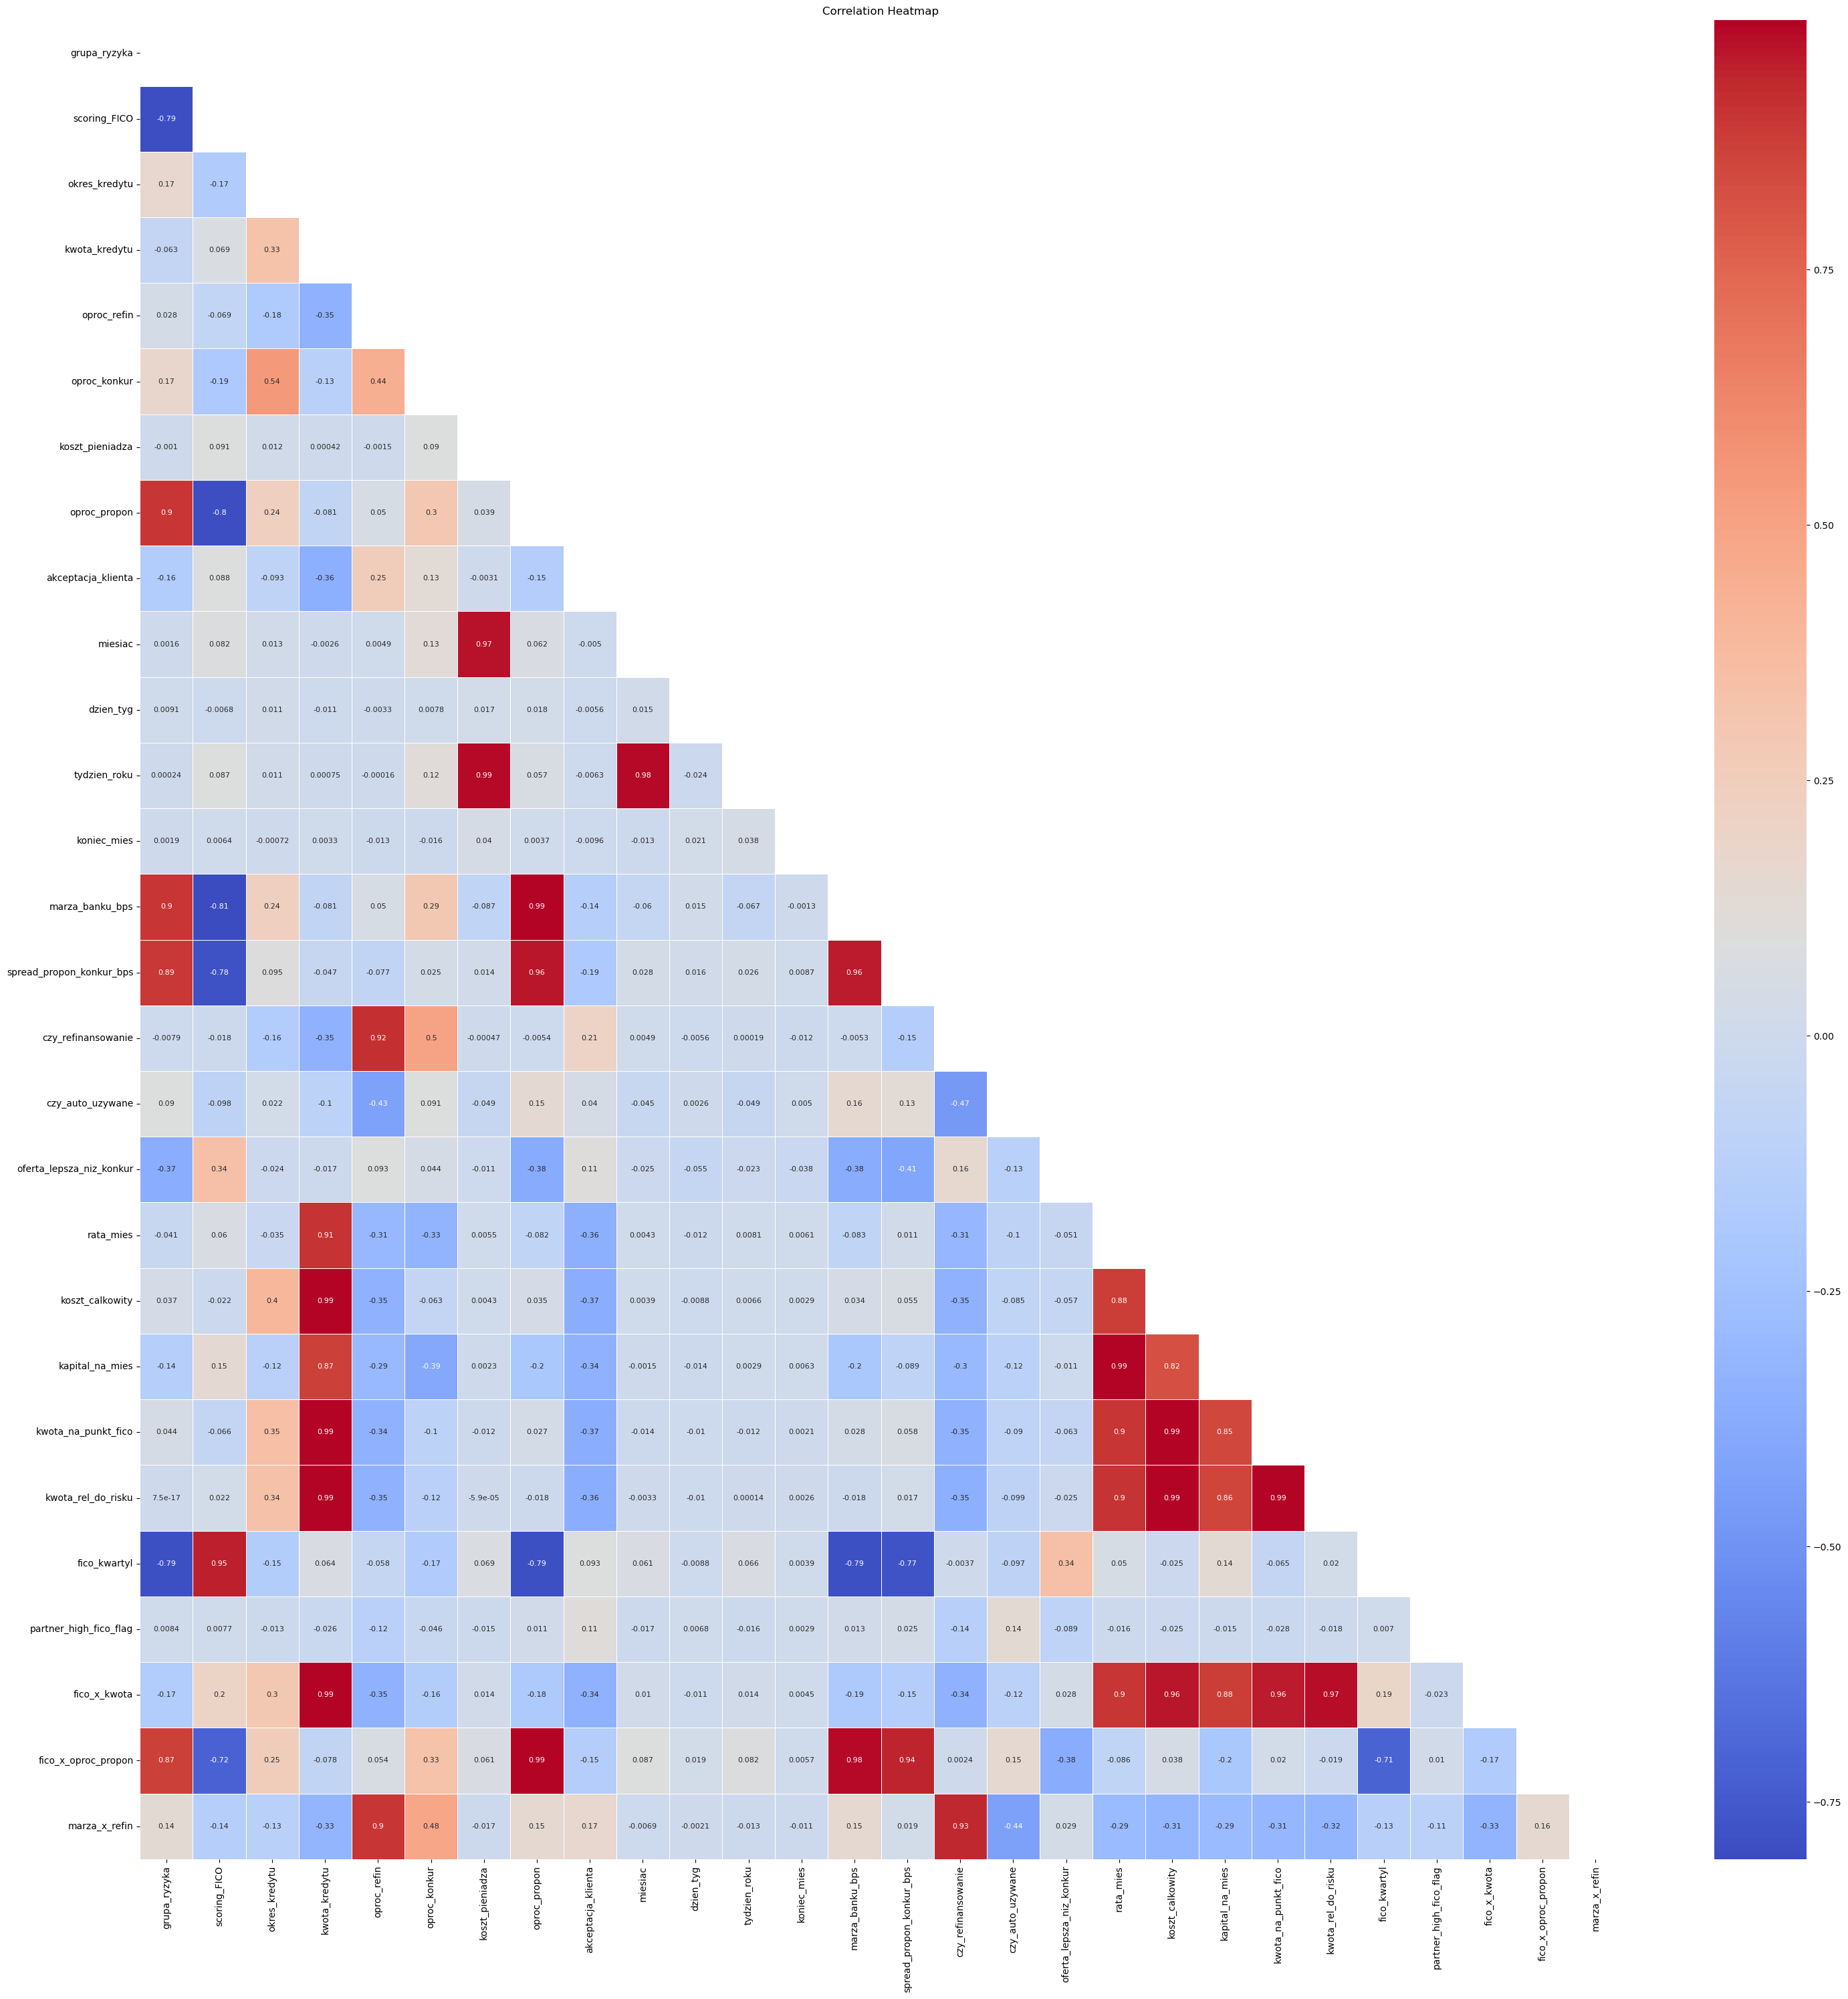

In [97]:
df_numeric = df_new.select_dtypes(include=['number'])

plt.figure(figsize=(30, 30))
corr = df_numeric.corr()
mask = np.triu(np.ones_like(corr))
sns.heatmap(corr, annot=True, mask=mask, cmap='coolwarm', linewidth=0.5, annot_kws={'size': 8})
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

In [98]:
num_cols = df_new.select_dtypes(include=[np.number]).columns # wyciągnięcie kolumn numerycznych (int, float, bool)
corr_mtx = df_new[num_cols].corr() # macierz korelacji Pearsona

# tworzenie tylko górnego trójkąta macierzy bez przekątnej
pairs = (corr_mtx.where(np.triu(np.ones(corr_mtx.shape), k=1).astype(bool))
            .stack()
            .reset_index()
            .rename(columns={'level_0':'feature_1', 'level_1':'feature_2', 0:'correlation'}))

# wyyświetlenie w kolejności malejącej tylko par zmiennych, które są ze sobą skorelowane na poziomie powyżej abs(0,5)
threshold = 0.5 
high_corr = (pairs.loc[pairs['correlation'].abs() > threshold]
                    .sort_values(by='correlation', key=np.abs, ascending=False)
                    .reset_index(drop=True))

high_corr

,feature_1,feature_2,correlation
0,koszt_calkowity,kwota_na_punkt_fico,0.994106
1,oproc_propon,marza_banku_bps,0.992021
2,kwota_kredytu,kwota_rel_do_risku,0.991659
3,oproc_propon,fico_x_oproc_propon,0.991048
4,kwota_kredytu,koszt_calkowity,0.990013
5,koszt_calkowity,kwota_rel_do_risku,0.989777
6,rata_mies,kapital_na_mies,0.989541
7,kwota_kredytu,fico_x_kwota,0.989259
8,kwota_kredytu,kwota_na_punkt_fico,0.989002
9,kwota_na_punkt_fico,kwota_rel_do_risku,0.988028


In [99]:
num_cols = df_new.select_dtypes(include=[np.number]).columns # wyciągnięcie kolumn numerycznych (int, float, bool)
X = df_new[num_cols].copy()

# 2) bool → int, żeby były czyste liczby
X.loc[:, X.dtypes == "bool"] = X.loc[:, X.dtypes == "bool"].astype(int) # zamienienie typu danych zmiennych bool na int

X["intercept"] = 1.0 # dodanie stałej (intercept)

# obliczenie VIF
vif = (pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])],index=X.columns,name="VIF")
    .to_frame()
    .drop(index="intercept")           # usunięcie wyliczania kolinearność dla interceptu
    .sort_values("VIF", ascending=False))

vif

E:\Programy2\Anaconda\envs\praca_magisterska3\lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,VIF
spread_propon_konkur_bps,inf
oproc_konkur,inf
koszt_pieniadza,inf
oproc_propon,inf
marza_banku_bps,inf
kwota_kredytu,9.249746e+04
kwota_na_punkt_fico,2.342621e+04
fico_x_kwota,2.267403e+04
rata_mies,4.441636e+03
kapital_na_mies,3.790076e+03


Niektóre zmienne w obecnym zbiorze danych okazały się być wysoko skorelowane i współliniowe. Nie trzeba natomiast usuwać tych niektórych zmiennych w zależności, jaki model zostanie użyty do trenowania. Można przed treningiem także zredukować wymiary zbioru za pomocą np. PCA. Można także nie brać pod uwagę niektórych zmiennych w modelu.

In [104]:
# -----------------------------------------------------------
# 1.  Funkcja licząca WoE i IV dla pojedynczej kolumny
# -----------------------------------------------------------
def calculate_woe_iv(data: pd.DataFrame,
                     feature: str,
                     target: str,
                     bins: int = 10):
    """
    Zwraca krotkę (IV, df_woe):
    • IV  –  wartość Information Value dla zmiennej `feature`
    • df_woe – tabela bin ↔ WoE (użyteczne do późniejszego kodowania)

    Parametry:
    ----------
    data    : DataFrame z danymi
    feature : nazwa kolumny predyktora
    target  : nazwa kolumny celu (binarny 0/1)
    bins    : liczba kwantylowych przedziałów dla zmiennych numerycznych
    """
    tmp = data[[feature, target]].copy()

    # --- BINNING ---------------------------------------------------
    if pd.api.types.is_numeric_dtype(tmp[feature]):
        # kwantylowe „koszyki” (równoliczne), duplicates='drop'
        tmp['bin'] = pd.qcut(tmp[feature], q=bins, duplicates='drop')
    else:
        # zmienna kategoryczna – każdy poziom = osobny bin
        tmp['bin'] = tmp[feature]

    # --- STATYSTYKI na celu ---------------------------------------
    grp = tmp.groupby('bin', observed=False)[target]
    stats = grp.agg(total='count', events='sum').astype(float)
    stats['non_events'] = stats['total'] - stats['events']

    # jeśli w którymś binie brak zdarzeń lub nie-zdarzeń,
    # dokładamy małe „oczeko” (0.5) – tzw. smoothing Laplace’a
    stats.loc[stats['events'] == 0, 'events'] = 0.5
    stats.loc[stats['non_events'] == 0, 'non_events'] = 0.5

    # --- Udziały + WoE --------------------------------------------
    stats['dist_events']     = stats['events']     / stats['events'].sum()
    stats['dist_non_events'] = stats['non_events'] / stats['non_events'].sum()

    stats['woe'] = np.log(stats['dist_events'] / stats['dist_non_events'])
    stats['iv']  = (stats['dist_events'] - stats['dist_non_events']) * stats['woe']

    iv_value = stats['iv'].sum()
    stats    = stats.reset_index()

    return iv_value, stats


# -----------------------------------------------------------
# 2.  Pętla po wszystkich kolumnach DataFrame `df_new`
# -----------------------------------------------------------
target = 'akceptacja_klienta'
iv_list = []

for col in df_new.columns.drop(target):
    try:
        iv, _ = calculate_woe_iv(df_new, col, target)
        iv_list.append((col, iv))
    except Exception as e:
        # gdyby jakaś kolumna była cała NaN lub 100 % tego samego,
        # zapisujemy informację diagnostyczną i lecimy dalej
        print(f'Pomijam {col}: {e}')

# -----------------------------------------------------------
# 3.  Ranking IV
# -----------------------------------------------------------
iv_df = (
    pd.DataFrame(iv_list, columns=['feature', 'IV'])
      .sort_values('IV', ascending=False)
      .reset_index(drop=True)
)

iv_df  # w notebooku zobaczysz ładną tabelkę

,feature,IV
0,rata_mies,1.004426
1,kwota_na_punkt_fico,0.967191
2,koszt_calkowity,0.959483
3,kwota_rel_do_risku,0.944293
4,kwota_kredytu,0.918627
5,kapital_na_mies,0.899114
6,fico_x_kwota,0.845774
7,oproc_refin,0.283370
8,spread_propon_konkur_bps,0.231399
9,oproc_konkur,0.212418


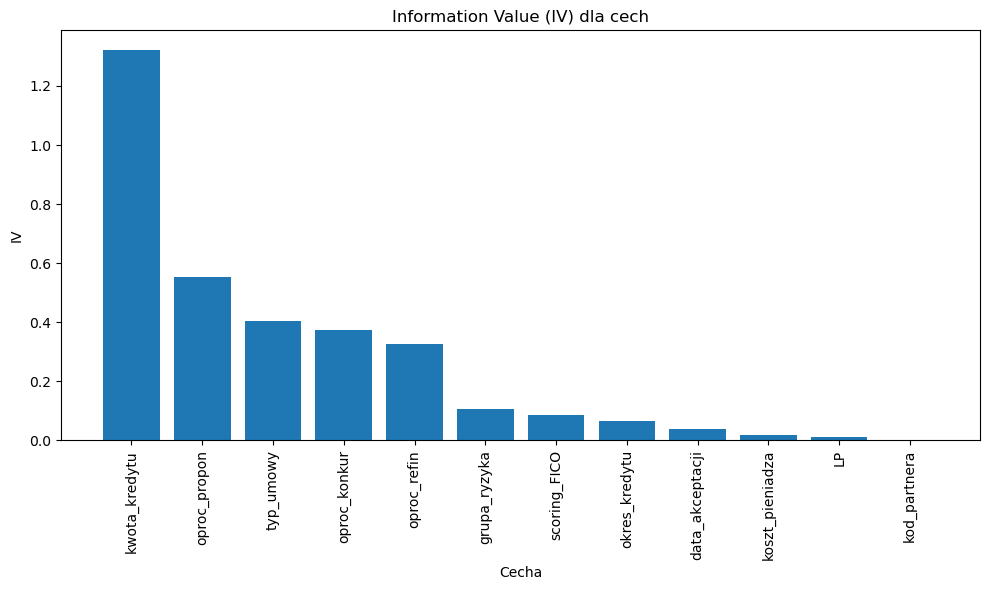

In [18]:
# 5.2 Wykres słupkowy IV
plt.figure(figsize=(10,6))
plt.bar(iv_df['feature'], iv_df['IV'])
plt.xticks(rotation=90)
plt.title('Information Value (IV) dla cech')
plt.xlabel('Cecha')
plt.ylabel('IV')
plt.tight_layout()
plt.show()

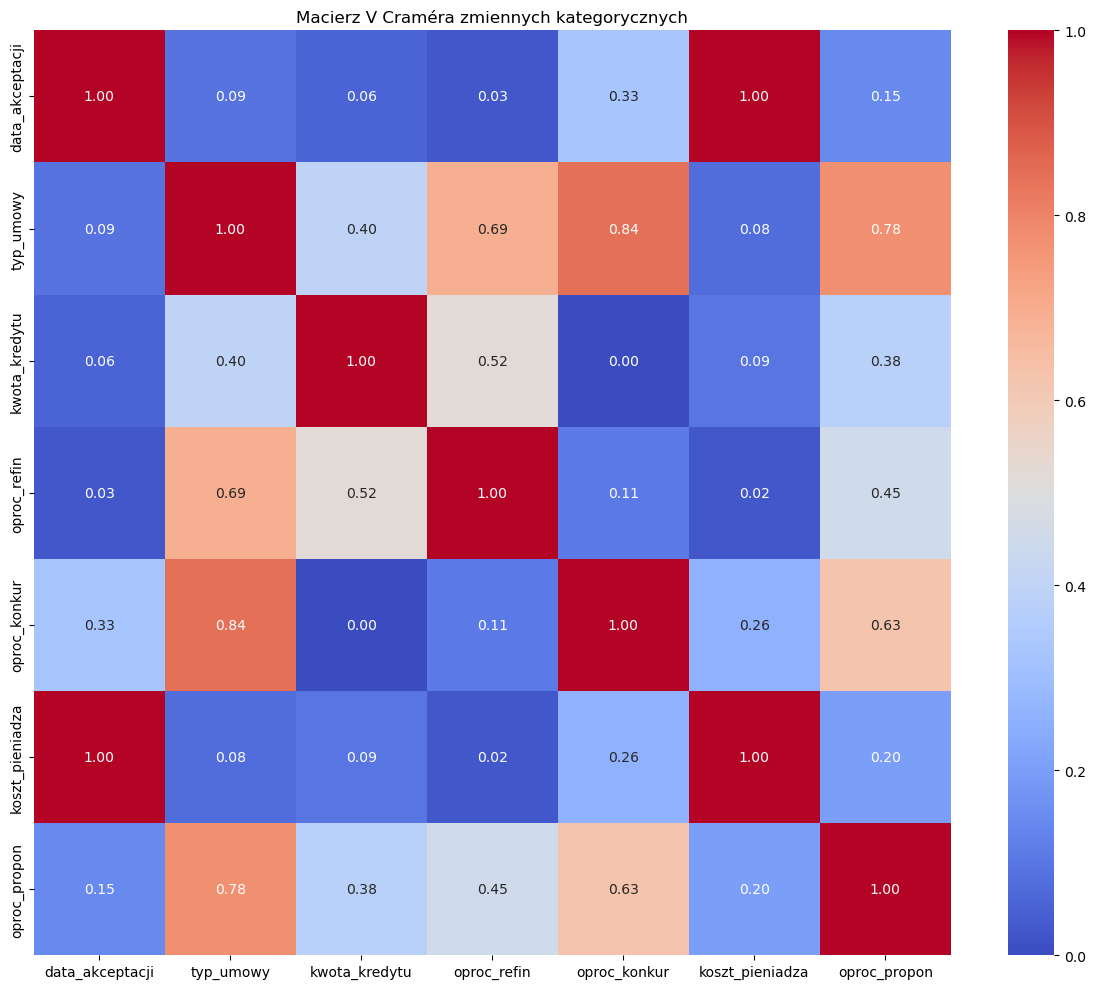

In [20]:
# 6. V Craméra (Twój kod)
def cramers_v(x, y):
    cm   = pd.crosstab(x, y)
    chi2 = chi2_contingency(cm)[0]
    n    = cm.values.sum()
    phi2 = chi2 / n
    r,k  = cm.shape
    # korekcja:
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr    = r - ((r-1)**2)/(n-1)
    kcorr    = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1),(rcorr-1)))

# Wyliczenie i heatmapa pełnej macierzy
cr_cols = categorical.columns
cr_mat  = pd.DataFrame(index=cr_cols, columns=cr_cols)
for c1 in cr_cols:
    for c2 in cr_cols:
        try:
            cr_mat.loc[c1,c2] = cramers_v(df[c1], df[c2])
        except:
            cr_mat.loc[c1,c2] = np.nan
cr_mat = cr_mat.astype(float)

plt.figure(figsize=(12,10))
sns.heatmap(cr_mat, annot=True, cmap="coolwarm", fmt=".2f")
plt.title('Macierz V Craméra zmiennych kategorycznych')
plt.tight_layout()
plt.show()

In [ ]:
# 7. Dodatkowe wykresy (mój + Twój kod)
# 7.1 Matplotlib (już było wyżej)
# 7.2 Seaborn histplot
for col in numeric.columns:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col], kde=True)
    plt.title(f'Rozkład zmiennej {col}')
    plt.xlabel(col)
    plt.ylabel('Liczba obserwacji')
    plt.tight_layout()
    plt.show()

In [ ]:
# 8. Zapis wyników IV do pliku CSV (Twój kod)
iv_df.to_csv('information_value_wyniki.csv', index=False)